In [1]:
from ime_pylib import scan_tools as sc

import matplotlib.pyplot as plt
import numpy as np
import sympy
import scipy as sp
from scipy.optimize import curve_fit

from scipy.optimize import fsolve
import math

In [2]:
# sorted specific files that should be loaded into different folders
# as to not overload memory with useless data
sc.set_path("./IME_datfiles/empty")
res_e = sc.scan_load(623,700)
sc.set_path("./IME_datfiles/h2o/")
res_h2o = sc.scan_load(629,710)
sc.set_path("./IME_datfiles/d2o/")
res_d2o = sc.scan_load(646,700)
sc.set_path("./IME_datfiles/h2olipid/")
res_h2olip = sc.scan_load(650,720)
sc.set_path("./IME_datfiles/d2olipid/")
res_d2olip = sc.scan_load(655,720)
# Im sorry it prints this much, but you can just comment out the two lines in that read " else: print("No or multiple [...]" in scan_tools.py
res_h2olip

File: ./IME_datfiles/empty/MKA_000623.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/empty/MKA_000688.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/empty/MKA_000700.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000629.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000643.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000644.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/d2o/MKA_000646.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/d2o/MKA_000647.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/d2o/MKA_000698.mat loaded . top_function: measure_c_bridge_li

In [3]:
# generic empty resonance frequency equation
def model(f, Ccl, Cfr, f0, Q):
    x = f/f0
    return Ccl + (Cfr-Ccl)/(1 - x**2 + 1j*x/Q)

# curve fits by least-square integration to given model, starting from p0
def fit(var_model, fdata, ydata, p0):
    
    def fit_func(fdata, *args):
        m = var_model(fdata, *args)
        return np.abs(m)
    
    ydata_real = np.abs(ydata)
    popt, _ = curve_fit(fit_func, fdata, ydata_real, p0)
    return popt

# 
def makefits(var_model, data, p0, S=0, s=900, e=1200):
    
    if var_model == model:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0)))
    
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(model, data[i].fr_bridge, data[i].C_bridge, p0)

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = model(data[i].fr_bridge, *popt_data[i])
            
            p0= popt_data[i]

        return data_fit, popt_data
    
    if var_model == lineuptoC:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0[0])))
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(lineuptoC, data[i].fr_bridge, data[i].C_bridge, p0[i])

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = lineuptoC(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    if var_model == stiffmodel:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0[0])))
        for i in range(0, len(data)):
            # find values for parameters
            # s and e are used as starting and ending points for fits as fits the entire range are completely useless
            popt_data[i] = fit(stiffmodel, data[i].fr_bridge[s:e], S[i][s:e], p0[i])

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = stiffmodel(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    if var_model == filledmodel:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0[0])))
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(filledmodel, data[i].fr_bridge, data[i].C_bridge, p0[i])

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = filledmodel(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    raise ValueError("this function can not fit data to the model ", var_model)

In [4]:
Ccl_0 = 1.7e-8
Cfr_0 = 2e-8
f0_0 = 9.3e4
Q_0 = 100

p0 = Ccl_0, Cfr_0, f0_0, Q_0
Cfit_e, popt_C_e = makefits(model, res_e, p0)
Cfit_h2o, popt_C_h2o = makefits(model, res_h2o, p0)
Cfit_d2o, popt_C_d2o = makefits(model, res_d2o, p0)
Cfit_d2olip, popt_C_d2olip = makefits(model, res_d2olip, p0)
#Cfit_h2olip, popt_C_h2olip = makefits(model, res_h2olip, p0)
popt_C_d2o

array([[1.75914910e-08, 1.94994636e-08, 8.45035715e+04, 1.53222233e+02],
       [1.75894412e-08, 1.94962238e-08, 8.44975621e+04, 1.64114510e+02],
       [1.83461024e-08, 2.02928972e-08, 8.60382387e+04, 4.10124434e+02]])

In [5]:
ccycle = ['b', 'r', 'g', 'm', 'k', 'c']
def plotfigs(data, fit, *line, size=(8,6), imag = False, compare=False, alpha=1, xlim=(0,4e5), logscale=False, ylim=(0,0)):
    
    plt.figure(figsize = size)
    for i in range(len(data)):
        if compare == True:
            alpha = 0.6
            plt.plot(data[i].fr_bridge, data[i].C_bridge.real, ls='dotted', c= ccycle[i])
        plt.plot(data[i].fr_bridge, fit[i].real, ls='-',c = ccycle[i], alpha=alpha)
    
    for arg in line:
        if  arg[0] == 'x':
            plt.axvline(arg[1], linestyle=':', color='k')
        else:
            plt.axhline(arg[1], linestyle=':', color='k')
    plt.xlim(xlim)
    if logscale == True:
        plt.xscale('log')
    if ylim != (0,0):
        plt.ylim(ylim)
    plt.show()
        
    plt.figure(figsize = size)
    if imag == True:
        for i in range(len(data)):
            if compare == True:
                alpha = 0.6
                plt.plot(data[i].fr_bridge, data[i].C_bridge.imag, ls ='dotted', c=ccycle[i])
            plt.plot(data[i].fr_bridge, fit[i].imag, ls='-', c= ccycle[i], alpha=alpha)
        for arg in line:
            if arg[0] == 'x':
                plt.axvline(arg[1], linestyle=':', color='k')
            else:
                plt.axhline(arg[1], linestyle=':', color='k')
        plt.xlim(xlim)
        if logscale == True:
            plt.xscale('log')
        if ylim != (0,0):
            plt.ylim(ylim)
        plt.show()

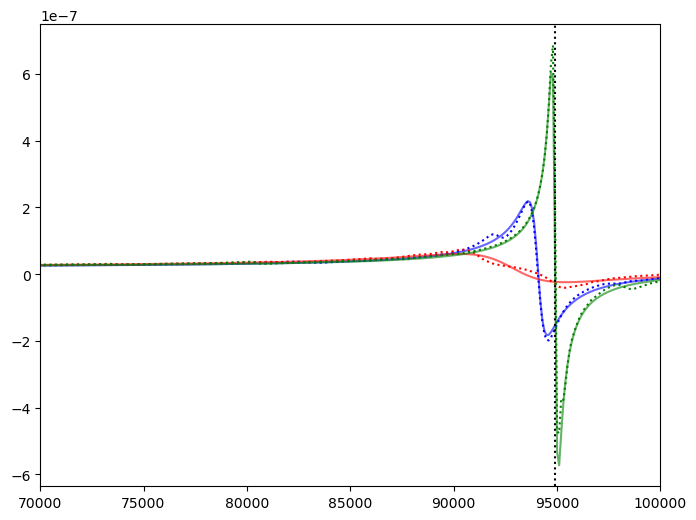

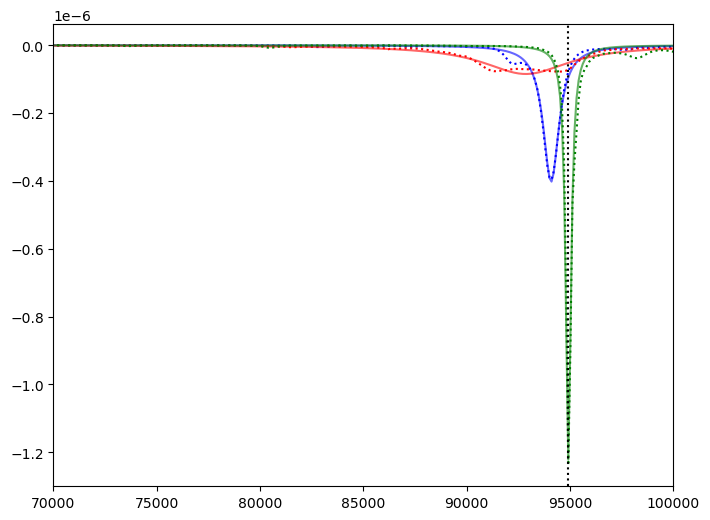

In [6]:
#plt.rc('font', size=12)
plotfigs(res_e, Cfit_e, ('x', popt_C_e[2][2]), compare=True, xlim = (7e4,1e5),imag=True)

## normalize capacitance

$$F(f) = \frac{C_m(f) - C_{cl}}{C_{fr} - C_{cl}}$$

In [7]:
def normcap(Cm,Ccl,Cfr):
    return (Cm - Ccl)/(Cfr - Ccl)

def normloop(data, popt):
    F = np.zeros_like(data)
    for i in range(0, len(data)):
        F[i] = normcap(data[i].C_bridge, popt[i][0], popt[i][1])
    return F

In [8]:
F_e = normloop(res_e, popt_C_e)
F_h2o = normloop(res_h2o, popt_C_h2o)
F_d2o = normloop(res_d2o, popt_C_d2o)
F_d2olip = normloop(res_d2olip, popt_C_d2olip)
#F_h2olip = normloop(res_h2olip, popt_C_h2olip)

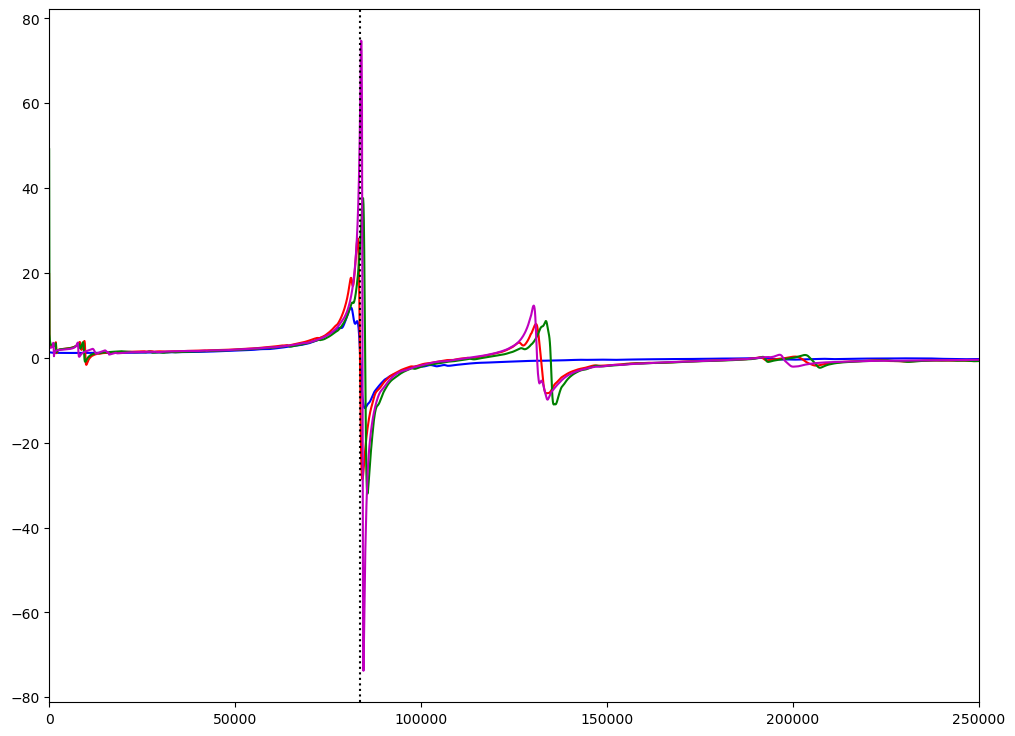

(0.0, 250000.0)

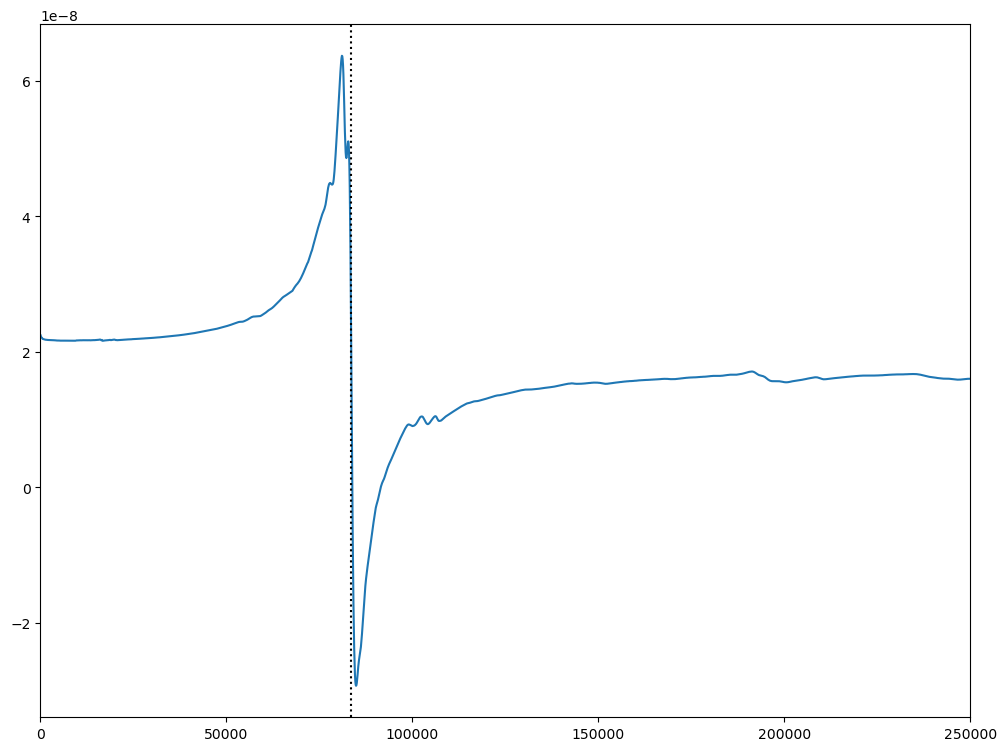

In [9]:
plotfigs(res_d2olip, F_d2olip, ('x', popt_C_d2olip[0][2]), size = (12,9), xlim=(0,2.5e5))
# for reference
plt.plot(res_d2olip[0].fr_bridge, res_d2olip[0].C_bridge.real)
plt.axvline(popt_C_d2olip[0][2], ls=':', c='k')
plt.xlim(0,2.5e5)

In [10]:
m = 0.005
r0 = 0.01
L = m/(4*np.pi*(r0**2))**2
V = (4/3)*np.pi*(r0**3)

### $S_{liq}(\omega)=\frac{1}{V}\left(K_S-\frac{1}{15}\rho \omega ^2r_0^2\right)$

In [11]:
def quasistatic(f, Ks, rho, r=0.01, V = (4/3)*np.pi*(0.01**3)):
    omega = np.pi*2*f
    return 1/V*(Ks-1/15*rho*omega**2*r**2)

$$ \omega_{res} : 1-\left(\frac{\omega}{\omega_0}\right)^2+\frac{K}{V}g\left(\frac{\omega}{\omega_c}\right) = 0$$

$$g(x) = -\frac{1}{3} \frac{x^2 \sin x}{x \cos x - \sin x} \ ,\ \omega_c = \sqrt{ \frac{K}{\rho} } \frac{1}{r}$$

In [12]:
def lineuptoC(f, fc, A, B):
    x = f/fc
    return 1 - (x*B)**2 - A*(x**2*np.sin(x))/(x * np.cos(x) - np.sin(x))

In [13]:
p0_d2o_0 = [1.6e-08, 1.5e+01, 1.88e+04,]
p0_d2o_1 = [1.6e-08, 1.5e+01, 1.88e+04,]
p0_d2o_2 = [1.8e-08, 1.5e+01, 1.92e+04,]

p0_h2o_0 = [1.8e-08, 1.5e+01, 1.965e+04]
p0_h2o_1 = [1.8e-08, 1.5e+01, 1.967e+04]
p0_h2o_2 = [1.8e-08, 1.5e+01, 1.967e+04]

p0_d2olip_0 = [1.8e-08, 1.5e+01, 1.86e+04]
p0_d2olip_1 = [1.8e-08, 1.5e+01, 1.865e+04]
p0_d2olip_2 = [1.8e-08, 1.5e+01, 1.9e+04]
p0_d2olip_3 = [1.8e-08, 1.5e+01, 1.89e+04]

[2.7200238139624133e-06, -2.4523440737833635e-07, 8.181591145239864e-06]
[-86578739556540.4, -126569791857159.89, -378178787702968.1]
[1.4878913531332327, 6.053292285403787, 2.814082542283902]
[0.6609964130955166, 1.0248947596421056, -0.5865312525267135]
[-1.731006573506843, -4.04042161284803, -5.904635011225359]


/tmp/ipykernel_68982/728096693.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (x*B)**2 - A*(x**2*np.sin(x))/(x * np.cos(x) - np.sin(x))
/tmp/ipykernel_68982/2806333014.py:7: RuntimeWarning: invalid value encountered in multiply
  data_fit_imag = data_fit*1j*1e-8


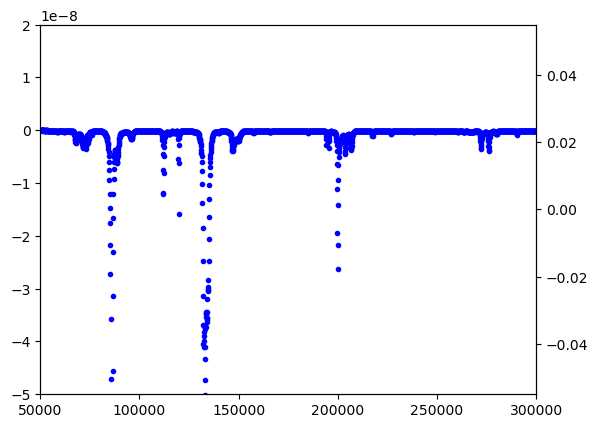

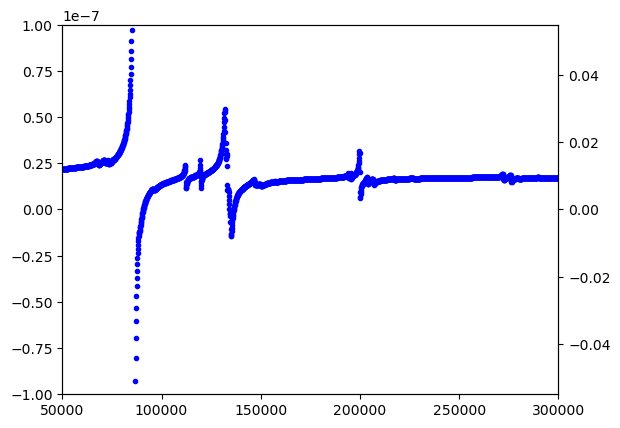

In [14]:
data = res_d2o
i = 2
p0 = [-1.8993356112400537e+21, -4.5317187032198734e+21, -1.0236775808447684e+22]
data_fit = np.zeros((1,4000), dtype=complex)
data_fit = lineuptoC(data[i].fr_bridge, *p0)

data_fit_imag = data_fit*1j*1e-8
fig, ax1 = plt.subplots()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.imag, '.b')
ax2 = ax1.twinx()
ax2.plot(data[i].fr_bridge, data_fit_imag.imag, '-r')
ax1.set_ylim(-5e-8,2e-8)
ax1.set_xlim(5e4,3e5)
#ax2.set_ylim(-0.5e-7,0)
#plt.ylim(-1,2e-7)
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.real, '.b')
ax2 = ax1.twinx()
ax2.plot(data[i].fr_bridge, data_fit.real, '-r')
ax1.set_ylim(-1e-7,1e-7)
ax1.set_xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

In [15]:
p0 = [[9e10, 20000, 9e6],[9e10, 20000, 9e6],[9e10, 20000, 9e6]]
S_fit_h2o, popt_S_h2o = makefits(lineuptoC, res_h2o, p0)

p0 = [[9e10, 20000, 9e6],[9e10, 20000, 9e6],[9e10, 20000, 9e6]]
S_fit_d2o, popt_S_d2o = makefits(lineuptoC, res_d2o, p0)

p0 = [[9e10, 20000, 9e6],[9e10, 20000, 9e6],[9e10, 20000, 9e6],[9e10, 20000, 9e6]]
S_fit_d2olip, popt_S_d2olip = makefits(lineuptoC, res_d2olip, p0)

/tmp/ipykernel_68982/728096693.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (x*B)**2 - A*(x**2*np.sin(x))/(x * np.cos(x) - np.sin(x))
/home/user00/Programs/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/tmp/ipykernel_68982/2275295252.py:3: RuntimeWarning: invalid value encountered in multiply
  data_fit_imag = data_fit*1j


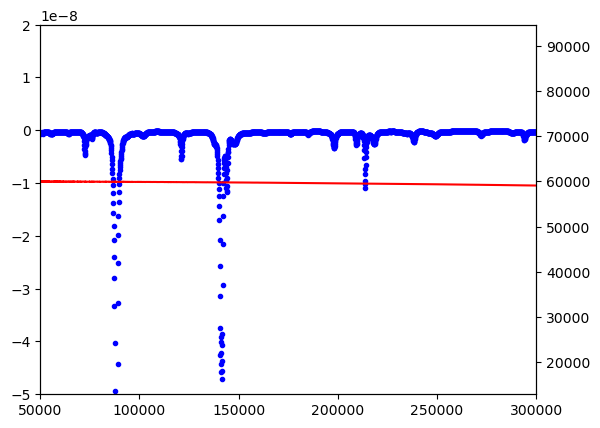

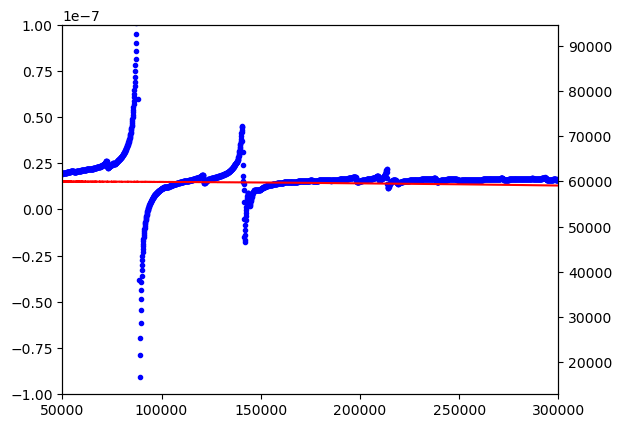

In [16]:
data=res_h2o
data_fit=S_fit_h2o
data_fit_imag = data_fit*1j
fig, ax1 = plt.subplots()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.imag, '.b')
ax2 = ax1.twinx()
ax2.plot(data[i].fr_bridge, data_fit_imag[i].imag, '-r')
ax1.set_ylim(-5e-8,2e-8)
ax1.set_xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.real, '.b')
ax2 = ax1.twinx()
ax2.plot(data[i].fr_bridge, data_fit[i].real, '-r')
ax1.set_ylim(-1e-7,1e-7)
ax1.set_xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

## function for fitting stiffness stuff

$$\frac{1}{C_{liq}(\omega)} =S_{liq}(\omega) = \frac{K}{V} g\left( \frac{\omega}{\omega_c} \right) \mathrm{where}\  g(x) = -\frac{1}{3} \frac{x^2 \sin x}{x \cos x - \sin x} \ ,\ \omega_c = \sqrt{ \frac{K}{\rho} } \frac{1}{r}$$

$$ \Rightarrow S(\omega) = - \frac{K}{4*\pi*r^3}\frac{ x^2 \sin (x)}{x \cos (x) - \sin (x)}\ ,\ x=\frac{\omega}{\omega_c} = \frac{\omega}{\sqrt{K/\rho}} *r $$


In [17]:
# define stiffness
def stiffmodel(f, K, fc):
    x = f/fc
    return (-1/(4*np.pi*(0.01)**3))*(K*((x**2)*np.sin(x))/(x * np.cos(x) - np.sin(x)))

In [18]:
def filledmodel(f, Ccl, Cfr, f0, Q, K, fc, L=.005/(4*np.pi*(r0**2))**2):
    x = f/f0
    S = stiffmodel(f, K, fc)
    return Ccl + (Cfr-Ccl)/(1 - x*x + 1j*x/Q + S/(L*(2*np.pi*f0)**2))

def filledloop(data, popt_C, popt_S, L):
    C_fit = np.zeros_like(data)
    for i in range(len(data)):
        C_fit[i] = filledmodel(data[i].fr_bridge, *popt_C[i], *popt_S[i], L)
    return C_fit

In [19]:
C_e = filledloop(res_e, popt_C_e, popt_S_e, L)
C_h2o = filledloop(res_h2o, popt_C_h2o, popt_S_h2o, L)
C_d2o = filledloop(res_d2o, popt_C_d2o, popt_S_d2o, L)
C_d2olip = filledloop(res_d2olip, popt_C_d2olip, popt_S_d2olip, L)
#C_h2olip = filledloop(res_h2olip, popt_C_h2olip, popt_S_h2olip, L)
#Cwater = filledmodel(res[10].fr_bridge, popt[10][0], popt[10][1], popt[10][2], popt[10][3], popt_Swater[0], popt_Swater[1], L)
np.shape(C_e[0])

NameError: name 'popt_S_e' is not defined

In [20]:
#plt.plot(res[10].fr_bridge, np.real(res[10].C_bridge), '.r')
#plt.plot(res[10].fr_bridge, np.real(Cwater), '-b', alpha =.7) 

plotfigs(res_e, C_e, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_h2o, C_h2o, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2o, C_d2o, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2olip, C_d2olip, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plotfigs(res_h2olip, C_h2olip, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plt.xlim(0,2.5e5)
#plt.ylim(-1e-7,1e-7)

NameError: name 'C_e' is not defined

In [21]:
def makep0s(popt_C, popt_S):
    newp0 = np.zeros((len(popt_C),len(popt_C[0])+len(popt_S[0])))
    print(newp0)
    for n in range(len(popt_C)):
        for i in range(len(popt_C[0])):
            newp0[n][i] = popt_C[n][i]
        for i in range(len(popt_S[0])):
            newp0[n][len(popt_C[0])+i] = popt_S[n][i]
    print(newp0)
    return newp0

p0 = makep0s(popt_C_e, popt_S_e)
C_e = makefits(filledmodel, res_e, p0)

p0 = makep0s(popt_C_h2o, popt_S_h2o)
C_h2o = makefits(filledmodel, res_h2o, p0)

p0 = makep0s(popt_C_d2o, popt_S_d2o)
C_d2o = makefits(filledmodel, res_d2o, p0)

#p0 = makep0s(popt_C_h2olip, popt_S_h2olip)
#C_h2olip = makefits(filledmodel, res_h2olip, p0)

p0 = makep0s(popt_C_d2olip, popt_S_d2olip)
C_d2olip = makefits(filledmodel, res_d2olip, p0)
#Cwater = filledmodel(res[10].fr_bridge, popt[10][0], popt[10][1], popt[10][2], popt[10][3], popt_Swater[0], popt_Swater[1], L)
np.shape(C_e[0])

NameError: name 'popt_S_e' is not defined

In [22]:
#plt.plot(res[10].fr_bridge, np.real(res[10].C_bridge), '.r')
#plt.plot(res[10].fr_bridge, np.real(Cwater), '-b', alpha =.7) 

plotfigs(res_e, C_e[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_h2o, C_h2o[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2o, C_d2o[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plotfigs(res_h2olip, C_h2olip[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2olip, C_d2olip[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plt.xlim(0,2.5e5)
#plt.ylim(-1e-7,1e-7)

NameError: name 'C_e' is not defined

In [23]:
def findmaxima(data, boundries):
    maxarray = np.zeros((len(data),3))
    for datfile in range(len(data)):
        max0 = boundry[0]
        for i in range(boundry[0]+1, boundry[1]):
            if data[datfile].C_bridge[i].imag < data[datfile].C_bridge[max0].imag:
                max0 = i
        
        max1 = boundry[1]
        for i in range(boundry[1]+1, boundry[2]):
            if data[datfile].C_bridge[i].imag < data[datfile].C_bridge[max1].imag:
                max1 = i
        
        max2 = boundry[2]
        for i in range(boundry[2]+1, boundry[3]):
            if data[datfile].C_bridge[i].imag < data[datfile].C_bridge[max2].imag:
                max2 = i
        
        maxarray[datfile] = max0, max1, max2
    
    return maxarray

In [24]:
boundry = [100, 1000, 1600, 2500]
max_h2o = findmaxima(res_h2o, boundry)
max_h2o = np.array(max_h2o, dtype=int)
print(max_h2o)
max_d2o = findmaxima(res_d2o, boundry)
max_d2o = np.array(max_d2o, dtype=int)
print(max_d2o)
max_d2olip = findmaxima(res_d2olip, boundry)
max_d2olip = np.array(max_d2olip, dtype=int)
print(max_d2olip)

[[ 878 1384 2122]
 [ 878 1398 2126]
 [ 882 1415 2136]]
[[ 844 1331 2011]
 [ 844 1330 2000]
 [ 860 1330 1999]]
[[ 836 1032 1950]
 [ 836 1323 2030]
 [ 849 1349 2053]
 [ 842 1310 1975]]


In [25]:
def findparams(data, x, p0, other):
    fitparameters = np.zeros((len(data),2))
    for i in range(len(data)):
        a = 1/other[i][2]
        def equations(p0):
            b, c = p0
            
            # peak positions
            x0, x1, x2 = data[i].fr_bridge[x[i][0]], data[i].fr_bridge[x[i][1]], data[i].fr_bridge[x[i][2]]
            
            # get parameters that give a 0 in the denominator at peaks
            return (1-(a*x0)**2-b*(c*x0)**2*np.sin(c*x0)/((c*x0)*np.cos(c* x0)-np.sin(c* x0)),
                1-(a*x1)**2-b*(c*x1)**2*np.sin(c*x1)/((c*x1)*np.cos(c*x1)-np.sin(c*x1)))
                #1-(a*x2)**2-b*(c*x2)**2*np.sin(c*x2)/((c*x2)*np.cos(c*x2)-np.sin(c*x2)))
                    
        fitparameters[i] =  fsolve(equations, p0, maxfev = 0)
    return fitparameters

In [26]:
def lineuptoC2(data, params):
    Jfit = np.zeros((len(data), 4000))
    for i in range(len(data)):
        x = data[i].fr_bridge * params[i][2]
        Jfit[i] = 1 - (x/params[i][2]*params[i][0])**2 - params[i][1]*(x**2*np.sin(x))/(x * np.cos(x) - np.sin(x))
    return Jfit

/home/user00/Programs/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/user00/Programs/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


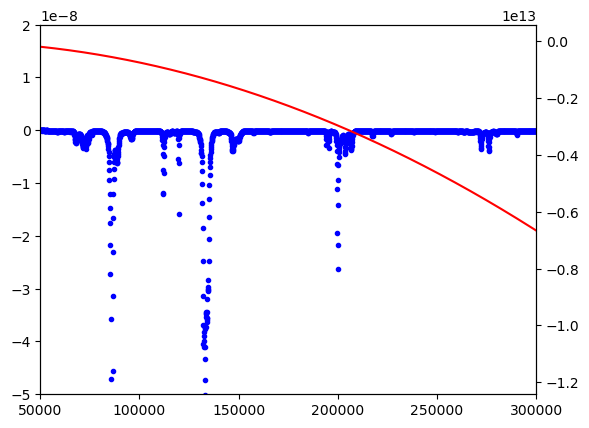

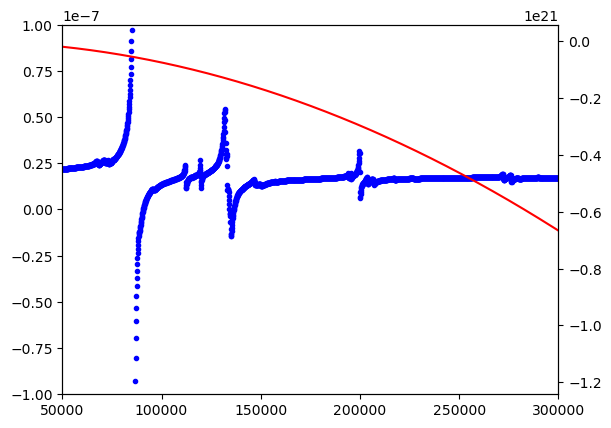

In [27]:
data = res_d2o
i = 2
p0 = 2.1e9 * m/(4*np.pi*(0.01**3))**2 * (popt_C_d2o[2][1] - popt_C_d2o[2][0]) , r0*1/np.sqrt(2.1e9/0.356)
params = findparams(data, max_d2o, p0, popt_C_d2o)
smth = np.zeros((len(data),3))
for i in range(len(data)):
    smth[i] = popt_C_d2o[i][2], *params[i]
data_fit = lineuptoC2(data, smth)

data_fit_imag = data_fit*1j*1e-8
fig, ax1 = plt.subplots()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.imag, '.b')
ax2 = ax1.twinx()
ax2.plot(data[i].fr_bridge, data_fit_imag[i].imag, '-r')
ax1.set_ylim(-5e-8,2e-8)
ax1.set_xlim(5e4,3e5)
#ax2.set_ylim(-0.5e-7,0)
#plt.ylim(-1,2e-7)
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.real, '.b')
ax2 = ax1.twinx()
ax2.plot(data[i].fr_bridge, data_fit[i].real, '-r')
ax1.set_ylim(-1e-7,1e-7)
ax1.set_xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

In [28]:
def stiffeq(f, fk, K, Ccl, Cfr, f0, Q, L, r):
        A = -1/(3 * V) * (Cfr - Ccl) / (L*(2*np.pi*f0)**2)
        return Ccl + (Cfr-Ccl)/(1 - (f/f0)**2 + 1j*f/(f0*Q) + A * K * (f/fk)**2 * np.sin(f/fk) / (f/fk * np.cos(f/fk) * np.sin(f/fk)) )

def fitfull(fdata, ydata, p0, otherp):
    Ccl, Cfr, f0, Q, L, r = otherp
    def stiffeq(f, fk, K, Ccl=Ccl, Cfr=Cfr, f0=f0, Q=Q, L=L, r=r):
        A = -1 * (Cfr - Ccl) / (L*(2*np.pi*f0)**2)
        return Ccl + (Cfr-Ccl)/(1 - (f/f0)**2 + 1j*f/(f0*Q) + A * K * (f/fk)**2 * np.sin(f/fk) / (f/fk * np.cos(f/fk) * np.sin(f/fk)) )

    def fit_func(fdata, *args):
        m = stiffeq(fdata, *args)
        return np.abs(m)
    
    ydata_real = np.abs(ydata)
    popt, _ = curve_fit(fit_func, fdata, ydata_real, p0)
    return popt

def findomegak(data, restrainedps, p0):
    
    fitparamsreal = fitparameters = np.zeros((len(data),2))
    Jfitreal = Jfit = np.zeros((len(data),4000))
    
    for i in range(len(data)):
        fitparameters[i] = fitfull(data[i].fr_bridge, data[i].C_bridge, p0, restrainedps[i])
        
        Jfit = stiffeq(data[i].fr_bridge, *fitparameters[i], *restrainedps[i])
        
        fitparamsreal[i] = np.abs(fitparameters[i])
        Jfitreal = stiffeq(data[i].fr_bridge, *fitparamsreal[i], *restrainedps[i])
        
    return Jfit, fitparameters, Jfitreal, fitparamsreal

In [29]:
restrained_d2o = np.zeros((len(res_d2o), 6))
for i in range(len(res_d2o)):
    Ccl, Cfr, f0, Q = popt_C_d2o[i]
    r = 0.01
    r0 = 0.01
    m =0.05
    L = m/(4*np.pi*(r0**3))**2
    #V = (4/3)*np.pi*(r0**3)
    restrained_d2o[i] = Ccl, Cfr, f0, Q, L, r
p0 = 1/r0*np.sqrt(2.1e9/0.356), 2.1e9
a, b, c, d = findomegak(res_d2o, restrained_d2o, p0)

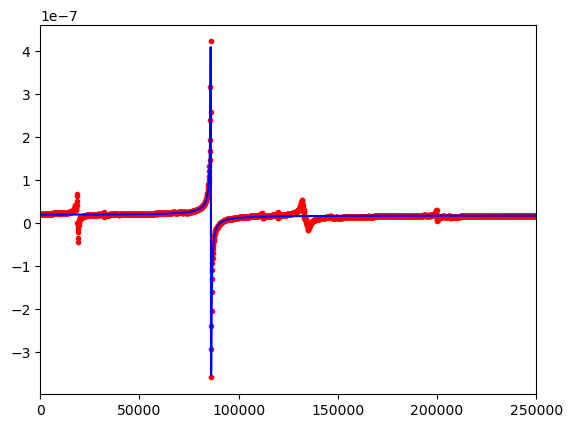

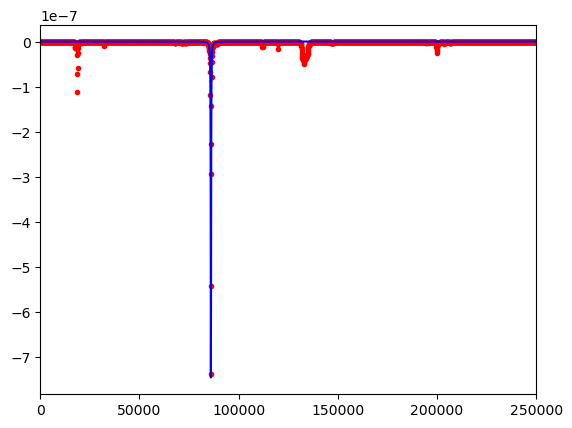

In [30]:
data = res_d2o
i = 2

plt.plot(data[i].fr_bridge, data[i].C_bridge.real, '.r')
plt.plot(data[i].fr_bridge, a.real, '-b')
plt.xlim(0,2.5e5)
plt.show()

plt.plot(data[i].fr_bridge, data[i].C_bridge.imag, '.r')
plt.plot(data[i].fr_bridge, a.imag, '-b')
plt.xlim(0,2.5e5)
plt.show()

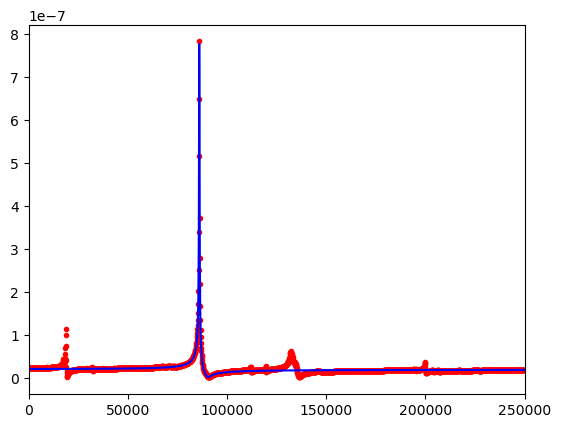

In [32]:
data = res_d2o
i = 2

plt.plot(data[i].fr_bridge, np.abs(data[i].C_bridge), '.r')
plt.plot(data[i].fr_bridge, np.abs(a), '-b')
plt.xlim(0,2.5e5)
plt.show()